In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parsmap/ParsMap.xlsx


# Sources
- https://tuanatran.medium.com/fine-tuning-large-language-model-with-hugging-face-pytorch-adce80dce2ad
- https://www.kaggle.com/code/shayanbemanian/persian-informal-to-formal-transformation

# W&B first of all:)

In [2]:
import warnings
warnings.filterwarnings('ignore') 
# ------------------------
!pip uninstall -y --quiet wandb
!pip install --quiet wandb==0.17.5 
# ------------------------
import wandb
!wandb offline
!wandb disabled
# ------------------------
import os
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.4 MB/s eta 0:00:0000:0100:01
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


# Install libraries

In [3]:
!pip install --quiet --upgrade datasets transformers evaluate sentencepiece accelerate 
!pip install --quiet dadmatools[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 11.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 75.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00

In [4]:
!pip install --quiet hazm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 13.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 86.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 95.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.3 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.3 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4

# Libraries

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from dadmatools.normalizer import Normalizer

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoConfig, GPT2LMHeadModel, GPT2Config, get_linear_schedule_with_warmup

import seaborn as sns
import matplotlib.pyplot as plt

import re
import random
import time
import datetime
import os

2025-08-14 07:58:30.009082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755158310.266389      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755158310.340531      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
tqdm.pandas()

# Read input data

In [7]:
df_parsmap = pd.read_excel("/kaggle/input/parsmap/ParsMap.xlsx")
df_parsmap.head()

,inFormalForm,formalForm,formalWords,inFormalWords
0,من دوس دارم برم خونه درس بخونم.,من دوست دارم که به خانه بروم تا درس بخوانم.,من/دوست/دارم/بروم/خانه/درس/بخوانم,من/دوس/دارم/برم/خونه/درس/بخونم
1,میتونی منو ببری خونمون یکم نون وردارم؟,می‌توانی من را به خانه‌مان ببری تا کمی نان برد...,می‌توانی/من را/ببری/خانه‌مان/کمی/نان/بردارم,میتونی/منو/ببری/خونمون/یکم/نون/وردارم
2,رفتم درمونگاه واسه بچم دوا بگیرم، یهو بارون گرفت,به درمانگاه رفتم تا برای بچه‌ام دوا بگیرم که ی...,رفتم/درمانگاه/برای/بچه‌ام/دوا/بگیرم/یکهو/باران...,رفتم/درمونگاه/واسه/بچم/دوا/بگیرم/یهو/بارون/گرفت
3,اون که خدا شاهده مث دیوونه هاس,خدا شاهد است که او مثل دیوانه‌ها است.,شاهد است/او/که/خدا/مثل/دیوانه‌ها است,شاهده/اون/که/خدا/مث/دیوونه هاس
4,یه سری آدما هستن که هر قدر خوبی کنی اصلن انگار...,یک سری آدم‌ها هستند که هر قدر هم خوبی کنی، اصل...,یک/سری/آدم‌ها/هستند/که/هر/قدر/خوبی/کنی/اصلاً/ا...,یه/سری/آدما/هستن/که/هر/قدر/خوبی/کنی/اصلن/انگار...


In [8]:
normalizer = Normalizer(
    full_cleaning=False,
    unify_chars=True,
    refine_punc_spacing=True,
    remove_extra_space=True,
    remove_puncs=False,
    remove_html=True,
    remove_stop_word=False,
    replace_email_with="<EMAIL>",
    replace_number_with=None,
    replace_url_with="",
    replace_mobile_number_with=None,
    replace_emoji_with=None,
    replace_home_number_with=None
)

text = 'من دوس دارم برم خونه درس بخونم    .'
print(normalizer.normalize(text))

من دوس دارم برم خونه درس بخونم.


In [9]:
def normalize_text(text):
    if pd.isna(text):
        return text
    return normalizer.normalize(str(text))

In [10]:
df_parsmap['formalForm'] = df_parsmap['formalForm'].progress_apply(normalize_text)
df_parsmap['inFormalForm'] = df_parsmap['inFormalForm'].progress_apply(normalize_text)

df_parsmap.head()

100%|██████████| 50014/50014 [00:06<00:00, 7817.67it/s]


,inFormalForm,formalForm,formalWords,inFormalWords
0,من دوس دارم برم خونه درس بخونم.,من دوست دارم که به خانه بروم تا درس بخوانم.,من/دوست/دارم/بروم/خانه/درس/بخوانم,من/دوس/دارم/برم/خونه/درس/بخونم
1,میتونی منو ببری خونمون یکم نون وردارم؟,می‌توانی من را به خانه‌مان ببری تا کمی نان برد...,می‌توانی/من را/ببری/خانه‌مان/کمی/نان/بردارم,میتونی/منو/ببری/خونمون/یکم/نون/وردارم
2,رفتم درمونگاه واسه بچم دوا بگیرم، یهو بارون گرفت,به درمانگاه رفتم تا برای بچه‌ام دوا بگیرم که ی...,رفتم/درمانگاه/برای/بچه‌ام/دوا/بگیرم/یکهو/باران...,رفتم/درمونگاه/واسه/بچم/دوا/بگیرم/یهو/بارون/گرفت
3,اون که خدا شاهده مث دیوونه هاس,خدا شاهد است که او مثل دیوانه‌ها است.,شاهد است/او/که/خدا/مثل/دیوانه‌ها است,شاهده/اون/که/خدا/مث/دیوونه هاس
4,یه سری آدما هستن که هر قدر خوبی کنی اصلن انگار...,یک سری آدم‌ها هستند که هر قدر هم خوبی کنی، اصل...,یک/سری/آدم‌ها/هستند/که/هر/قدر/خوبی/کنی/اصلاً/ا...,یه/سری/آدما/هستن/که/هر/قدر/خوبی/کنی/اصلن/انگار...


In [11]:
df_parsmap = df_parsmap.dropna(subset=["inFormalForm", "formalForm"])

In [12]:
df_parsmap["text"] = "<|startoftext|>" + "[Informal]" + df_parsmap["inFormalForm"].apply(lambda t: t.replace("    ", "<sep>").replace("\t", "<sep>")) + "[Formal]" + df_parsmap["formalForm"].apply(lambda t: t.replace("    ", "<sep>").replace("\t", "<sep>")) + "<|endoftext|>"

df_parsmap.head()

,inFormalForm,formalForm,formalWords,inFormalWords,text
0,من دوس دارم برم خونه درس بخونم.,من دوست دارم که به خانه بروم تا درس بخوانم.,من/دوست/دارم/بروم/خانه/درس/بخوانم,من/دوس/دارم/برم/خونه/درس/بخونم,<|startoftext|>[Informal]من دوس دارم برم خونه ...
1,میتونی منو ببری خونمون یکم نون وردارم؟,می‌توانی من را به خانه‌مان ببری تا کمی نان برد...,می‌توانی/من را/ببری/خانه‌مان/کمی/نان/بردارم,میتونی/منو/ببری/خونمون/یکم/نون/وردارم,<|startoftext|>[Informal]میتونی منو ببری خونمو...
2,رفتم درمونگاه واسه بچم دوا بگیرم، یهو بارون گرفت,به درمانگاه رفتم تا برای بچه‌ام دوا بگیرم که ی...,رفتم/درمانگاه/برای/بچه‌ام/دوا/بگیرم/یکهو/باران...,رفتم/درمونگاه/واسه/بچم/دوا/بگیرم/یهو/بارون/گرفت,<|startoftext|>[Informal]رفتم درمونگاه واسه بچ...
3,اون که خدا شاهده مث دیوونه هاس,خدا شاهد است که او مثل دیوانه‌ها است.,شاهد است/او/که/خدا/مثل/دیوانه‌ها است,شاهده/اون/که/خدا/مث/دیوونه هاس,<|startoftext|>[Informal]اون که خدا شاهده مث د...
4,یه سری آدما هستن که هر قدر خوبی کنی اصلن انگار...,یک سری آدم‌ها هستند که هر قدر هم خوبی کنی، اصل...,یک/سری/آدم‌ها/هستند/که/هر/قدر/خوبی/کنی/اصلاً/ا...,یه/سری/آدما/هستن/که/هر/قدر/خوبی/کنی/اصلن/انگار...,<|startoftext|>[Informal]یه سری آدما هستن که ه...


In [13]:
df_parsmap['text'][34]

'<|startoftext|>[Informal]از همه نظر عالیه ولی بزرگترین ایرادش اینه که صدای مکالمه در کمترین میزان ولوم هم انگار روی پخش کنه[Formal]از همه نظر عالی است؛ ولی بزرگ\u200cترین ایرادش این است که صدای مکالمه در کمترین میزان ولوم هم انگار روی پخش\u200cکن است.<|endoftext|>'

In [14]:
model_name_or_path = "HooshvareLab/gpt2-fa" # ViraIntelligentDataMining/PersianLLaMA-13B, ViraIntelligentDataMining/PersianLLaMA-13B-Instruct
                                            # universitytehran/SmolLM-135M-10M-word, universitytehran/PersianMind-v1.0
                                            # MaralGPT/Maral-7B-alpha-1

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>',
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    model_name_or_path,
    bos_token_id=tokenizer("<s>")["input_ids"][0],
    eos_token_id=tokenizer("</s>")["input_ids"][0],
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

# tokenizer.save_pretrained("/kaggle/working/gpt2/")
# config.save_pretrained("/kaggle/working/gpt2/")

# !wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /kaggle/working/gpt2/
# !wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /kaggle/working/gpt2/

tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

In [15]:
# tokenizer = AutoTokenizer.from_pretrained(
#     "/kaggle/working/gpt2",
#     bos_token='<s>',
#     eos_token='</s>',
#     pad_token='<pad>'
# )

print(tokenizer.encode("سلام بر شما"))
print(tokenizer.encode("<s>"))
print(tokenizer.encode("</s>"))
print(tokenizer.encode("<pad>"))
print(tokenizer.encode("<|startoftext|>"))
print(tokenizer.encode("<|endoftext|>"))
print(tokenizer.encode("<sep>"))

[8906, 327, 512]
[0]
[2]
[1]
[6]
[5]
[9]


In [16]:
texts = df_parsmap["text"].values.tolist()

print(len(texts))

50013


In [17]:
max_seq = 256

In [18]:
torch.manual_seed(42)

class MTGDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length=1024):
        self.tokenizer = tokenizer  # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the
            pad token.
            """

            encodings_dict = tokenizer('<s>' + txt + '</s>',
                                       truncation=True,
                                       max_length=max_length,
                                       padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not.
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [19]:
dataset = MTGDataset(texts, tokenizer, max_length=max_seq)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'There are 45011 samples for training, and 5002 samples for validation testing'

In [20]:
print(train_dataset[0][0][:100])
print(tokenizer.decode(train_dataset[0][0][:100]))

tensor([    0,     6,    69,  9081,  9942,  1353,    71,  8878,  1811,   564,
          547,   323, 12595,   662,    24,   747,  1994,   271,  1811,   814,
         4225,    69,    48, 33621,    71,  8878,   298,   564,   547,   323,
          326,   285,  7610,   662,    24,   747,   298,   814,  4225,  1994,
          590,    24,     5,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
<s><|startoftext|>[Informal]البته توی کشور ما که اینجوری نیست. همه آزادن توی فیلم ساختن[Formal]البته در کشور ما که این‌جوری نیست. همه در فیلم ساختن آزاد هستند.<|endoftext|></s><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [21]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

In [22]:
configuration = GPT2Config.from_pretrained(model_name_or_path, output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained(model_name_or_path, config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    print("------------------------ CUDA IS AVAILABLE -------------------------")
    torch.cuda.manual_seed_all(seed_val)

pytorch_model.bin:   0%|          | 0.00/485M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/485M [00:00<?, ?B/s]

------------------------ CUDA IS AVAILABLE -------------------------


In [23]:
epochs = 2
warmup_steps = 1e2
sample_every = 300

In [24]:
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=5e-4,
    eps=1e-8
)

In [25]:
# Total training steps is the number of data points, times the number of epochs.
# Essentially, epochs are training cycles, how many times each point will be seen by the model.

total_steps = len(train_dataloader) * epochs
print(total_steps)

# We can set a variable learning rate which will help scan larger areas of the
# problem space at higher LR earlier, then fine tune to find the exact model minima
# at lower LR later in training.

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

11254


In [26]:
sample_informal = df_parsmap['inFormalForm'][np.random.randint(0, len(df_parsmap['inFormalForm']))]
sample_input = f"<s><|startoftext|>[Informal]{sample_informal}[Formal]"
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
    do_sample=True,
    top_k=50,
    max_length=50,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
    gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
    gen_sample_output = gen_sample_output.replace("<|startoftext|>", "")
    gen_sample_output = gen_sample_output.replace("[Informal]", "\n")
    gen_sample_output = gen_sample_output.replace("[Formal]", "\n")
    gen_sample_output = gen_sample_output.replace("<|endoftext|>", "")
    gen_sample_output = gen_sample_output.replace("<s>", "")
    gen_sample_output = gen_sample_output.replace("</s>", "")
    gen_sample_output = gen_sample_output.replace("<sep>", "\n")

    print(f'Example output: {gen_sample_output}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<s><|startoftext|>[Informal]آمار افسردگی و خودکشی در خداناباورا بیشتر از بقیه هست[Formal]
Example output: 
آمار افسردگی و خودکشی در خداناباورا بیشتر از بقیه هست
 میزان مرگ و میر و خودکشی در خداناباورا خیلی بالاست 
» «Informal»، «Informal»،


In [27]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [28]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print()
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            # sample_poet = poets[np.random.randint(0, len(poets))]
            # sample_input = f"<s>{sample_poet}<|startoftext|>"
            sample_informal = df_parsmap['inFormalForm'][np.random.randint(0, len(df_parsmap['inFormalForm']))]
            sample_input = f"<s><|startoftext|>[Informal]{sample_informal}[Formal]"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<|startoftext|>", "")
                gen_sample_output = gen_sample_output.replace("[Informal]", "\n")
                gen_sample_output = gen_sample_output.replace("[Formal]", "\n")
                gen_sample_output = gen_sample_output.replace("<|endoftext|>", "")
                gen_sample_output = gen_sample_output.replace("<s>", "")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")

                print(f'Example output: {gen_sample_output}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print()
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

  0%|          | 0/2 [00:00<?, ?it/s]

Beginning epoch 1 of 2


  5%|▌         | 300/5627 [02:41<49:50,  1.78it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 300 of 5627. Loss:0.4220503866672516. Time:0:02:42


  5%|▌         | 301/5627 [02:42<55:05,  1.61it/s]

Example output: 
از اونجا زنگ میزنیم به مامانت میگیم، اگرم گفت نه از اونجا آژانس میگیریم برو خونه
از آنجا زنگ می‌خوریم به مامانت می‌گویم، اگر هم گفتم نه، از آنجا


 11%|█         | 600/5627 [05:31<47:27,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 11%|█         | 601/5627 [05:32<49:59,  1.68it/s]


Batch 600 of 5627. Loss:0.38652437925338745. Time:0:05:32
Example output: 
بعدش ببین واسه کی میمونه.
بعد آن دید برای کی می‌ماند.


 16%|█▌        | 900/5627 [08:21<44:34,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 16%|█▌        | 901/5627 [08:22<47:06,  1.67it/s]


Batch 900 of 5627. Loss:0.398492693901062. Time:0:08:22
Example output: 
نتیجشم یه گام به عقبه.
نمره‌ام یک‌کم بالاتر است.


 21%|██▏       | 1200/5627 [11:11<41:49,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 21%|██▏       | 1201/5627 [11:12<45:07,  1.63it/s]


Batch 1200 of 5627. Loss:0.39376914501190186. Time:0:11:12
Example output: 
یه جورایی شبیه به سیستم قرقره ایه
یک‌جورهایی شبیه به سیستم پنبه‌ای می‌شود.


 27%|██▋       | 1500/5627 [14:01<38:54,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1500 of 5627. Loss:0.5065863728523254. Time:0:14:02


 27%|██▋       | 1501/5627 [14:02<43:11,  1.59it/s]

Example output: 
فقط مشکل اینه من تا به اون چیزی که تو سرمه نرسم آروم نمیشم.
فقط مشکل این است که من تا به آن چیزی که در سرمه نرسم آرام نمی‌شدم.


 32%|███▏      | 1800/5627 [16:51<36:05,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 32%|███▏      | 1801/5627 [16:52<38:09,  1.67it/s]


Batch 1800 of 5627. Loss:0.4457574486732483. Time:0:16:52
Example output: 
بچه که بودم می دیدم که بچه ها به قطار سنگ می زنن بعدها فهمیدم هر کسی که در حال حرکته، سنگش می زنند
بچه که بودم می‌دیدم که بچه‌ها


 37%|███▋      | 2100/5627 [19:41<33:15,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2100 of 5627. Loss:0.41007593274116516. Time:0:19:42
Example output: 
شما و دوستانت اگر واقعا به فکر ایران بودید میموندید به مملکتتون خدمت میکردید
شما و دوستانت اگر واقعاً به فکر ایران بودید، به مملکت‌تان می‌موند


 43%|████▎     | 2400/5627 [22:31<30:29,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 43%|████▎     | 2401/5627 [22:32<32:26,  1.66it/s]


Batch 2400 of 5627. Loss:0.36985135078430176. Time:0:22:32
Example output: 
می دونه بهونه می گیری بی دلیل!
می‌گویند که بی‌دلیل می‌شوی!


 48%|████▊     | 2700/5627 [25:21<27:34,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 48%|████▊     | 2701/5627 [25:22<30:03,  1.62it/s]


Batch 2700 of 5627. Loss:0.41852590441703796. Time:0:25:22
Example output: 
من جای صاب‌مجلس بودم احتمالا چارتا فحش آبدار به آخونده می‌بستم.
من جای دیگر داشتم چارتا فحش آبدار به آخونده می‌دادم.


 53%|█████▎    | 3000/5627 [28:11<24:48,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 53%|█████▎    | 3001/5627 [28:12<26:13,  1.67it/s]


Batch 3000 of 5627. Loss:0.32313090562820435. Time:0:28:12
Example output: 
درس و مشق آخر عاقبتش رانندگی اسنپه.
درس و مشق آخر عاقبت او رانندگی اسنپ است.


 59%|█████▊    | 3300/5627 [31:01<21:58,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 59%|█████▊    | 3301/5627 [31:02<23:39,  1.64it/s]


Batch 3300 of 5627. Loss:0.33949601650238037. Time:0:31:02
Example output: 
نمیخواستم بگم اما راستش خیلی افسردم این روزا
نمی‌خواستم بگویم اما راستش خیلی من را دیوانه‌ای.


 64%|██████▍   | 3600/5627 [33:51<19:12,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 64%|██████▍   | 3601/5627 [33:52<20:51,  1.62it/s]


Batch 3600 of 5627. Loss:0.3813321888446808. Time:0:33:52
Example output: 
هر سختی باشه تو این راه، من بودم ک انتخاب کردمش و قبول کردم و میخاستم ادامه بدم
هر سختی که باشد، من بودم که انتخاب کردم و او را قبول کردم و قبول


 69%|██████▉   | 3900/5627 [36:41<16:17,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 69%|██████▉   | 3901/5627 [36:42<17:35,  1.63it/s]


Batch 3900 of 5627. Loss:0.5423680543899536. Time:0:36:42
Example output: 
همزمان تایم بیشتری رو به بچه ها برا بازی اختصاص بدین
همزمان تایم بیشتری را به بچه‌ها برای بازی اختصاص بدهید.


 75%|███████▍  | 4200/5627 [39:31<13:27,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 75%|███████▍  | 4201/5627 [39:32<14:38,  1.62it/s]


Batch 4200 of 5627. Loss:0.5634949207305908. Time:0:39:32
Example output: 
همچین اسمی مناسب یه سگ گرد و قلنبه و کله پوک ئه نه سگ بدبختی مثل من.
می‌دانم که اسمی مناسب یک سگ‌گردو‌نبه‌دردن


 80%|███████▉  | 4500/5627 [42:21<10:36,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4500 of 5627. Loss:0.4786156713962555. Time:0:42:22


 80%|███████▉  | 4501/5627 [42:22<11:45,  1.60it/s]

Example output: 
ولی صبر کن وقتی اومد به یه بهانه گوشیش رو می گیرم ازش چک می کنم
ولی صبر کن وقتی آمد به یک بهانه گوشی‌اش را می‌گیرم از آن چک می‌کنم


 85%|████████▌ | 4800/5627 [45:11<07:47,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4800 of 5627. Loss:0.3011714518070221. Time:0:45:12
Example output: 
اصن میرم ی تاپیک دیگ دنبال عخشم میگردم
اصن می‌روم تا یکی‌ذره دنبال عغاشش می‌گردم.


 91%|█████████ | 5100/5627 [48:01<04:58,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 91%|█████████ | 5101/5627 [48:02<05:13,  1.68it/s]


Batch 5100 of 5627. Loss:0.4074910283088684. Time:0:48:02
Example output: 
چوق تو آستینتون میکنن
چهوق در آستینتان می‌کنند.


 96%|█████████▌| 5400/5627 [50:51<02:08,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 96%|█████████▌| 5401/5627 [50:52<02:15,  1.67it/s]


Batch 5400 of 5627. Loss:0.4226727783679962. Time:0:50:52
Example output: 
فقط می خواد اوضاع رو تیره نشون بده.
فقط می‌خواهد اوضاع را تیره نشان بدهد.


100%|██████████| 5627/5627 [52:59<00:00,  1.77it/s]



Average Training Loss: 0.424960812495173. Epoch time: 0:53:00



 50%|█████     | 1/2 [54:55<54:55, 3295.45s/it]


Validation loss: 0.37150613175699126. Validation Time: 0:01:55

Beginning epoch 2 of 2


  5%|▌         | 300/5627 [02:49<50:16,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 300 of 5627. Loss:0.2736718952655792. Time:0:02:50


  5%|▌         | 301/5627 [02:50<55:55,  1.59it/s]

Example output: 
دقیقا همینطوره، مردا زن تو سری خور میخوان.
دقیقاً همین‌طور است، مردها زن‌ها زن در سری‌خور می‌خواهند.


 11%|█         | 600/5627 [05:39<47:27,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 600 of 5627. Loss:0.341401606798172. Time:0:05:40
Example output: 
اگه صد لایه ام ایزوگامشون کنید بازم معرفت ازشون چیکه میکنه
اگر صد لایه‌ام را ایزوگام کنید، باز هم معرفتشان چیکه می‌کند.


 16%|█▌        | 900/5627 [08:29<44:35,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 16%|█▌        | 901/5627 [08:30<47:16,  1.67it/s]


Batch 900 of 5627. Loss:0.3945237994194031. Time:0:08:30
Example output: 
این همون دسته که درد میکنه؟
این همان دسته است که درد می‌کند؟


 21%|██▏       | 1200/5627 [11:19<41:48,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 21%|██▏       | 1201/5627 [11:19<42:32,  1.73it/s]


Batch 1200 of 5627. Loss:0.2734927535057068. Time:0:11:20
Example output: 
من پدرم وقتی تصمیم گرف بره حج واجب بهش گفتم بابا بهتر نیست ک هزینه این سفر و بدی تا ی دختر ک وسع مالی نداره جهاز بخره بره سر زندگیش؟
من پدرم وقتی


 27%|██▋       | 1500/5627 [14:09<38:59,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 27%|██▋       | 1501/5627 [14:09<41:06,  1.67it/s]


Batch 1500 of 5627. Loss:0.27053457498550415. Time:0:14:10
Example output: 
مدام توی آداب معاشرت حساسند
مدام در آداب‌ معاشرت حساس هستند.


 32%|███▏      | 1800/5627 [16:59<36:08,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 32%|███▏      | 1801/5627 [16:59<38:18,  1.66it/s]


Batch 1800 of 5627. Loss:0.45525532960891724. Time:0:17:00
Example output: 
چقدر بعضی از پیام ناشناساتون گوگولیع.
چقدر بعضی از پیام ناشناسهایتان گوگولیع.


 37%|███▋      | 2100/5627 [19:49<33:14,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 37%|███▋      | 2101/5627 [19:49<34:55,  1.68it/s]


Batch 2100 of 5627. Loss:0.32912132143974304. Time:0:19:50
Example output: 
اگه محصلید ودرس میخونید اونقدر خودتونو درگیر نکنید که یهو به خودتون بیایید و ببینید چه فرصتهایی از دست رفته ولی دیگه نمیشه کاریش کرد.
اگر دانشجو هستید، آن‌قدر خودتان را


 43%|████▎     | 2400/5627 [22:38<30:26,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2400 of 5627. Loss:0.30799880623817444. Time:0:22:40
Example output: 
اینا خبر ندارن حیوونای باغ وحشم بااینکه زشت و حیوونن همه تحویلشون میگیرن!
خبر ندارند حیوان‌های باغ وحشی وحشی که در باغ وحشی هستند، چه‌قدر همه تحویل


 48%|████▊     | 2700/5627 [25:29<27:33,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 48%|████▊     | 2701/5627 [25:29<29:12,  1.67it/s]


Batch 2700 of 5627. Loss:0.33294177055358887. Time:0:25:30
Example output: 
این کار همسر شما یه جور حبس کردنه
این کار همسر شما یک جور حبس کردن است.


 53%|█████▎    | 3000/5627 [28:18<24:48,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 53%|█████▎    | 3001/5627 [28:19<26:23,  1.66it/s]


Batch 3000 of 5627. Loss:0.31553134322166443. Time:0:28:20
Example output: 
کافی بود یه بار بیاد ببینه من تو مغازه بیکارم یا با دوستهام شوخی می کنم، دیگه جرات نداشتم تو خونه بگم خسته ام
کافی بود یک بار بیاید ببیند من در مغازه بیکار هستم


 59%|█████▊    | 3300/5627 [31:08<21:57,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 59%|█████▊    | 3301/5627 [31:09<23:22,  1.66it/s]


Batch 3300 of 5627. Loss:0.23362530767917633. Time:0:31:09
Example output: 
منم میخواستم باش بازی کنم
من هم می‌خواستم که با او بازی کنم.


 64%|██████▍   | 3600/5627 [33:58<19:08,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 64%|██████▍   | 3601/5627 [33:59<20:11,  1.67it/s]


Batch 3600 of 5627. Loss:0.2551743686199188. Time:0:33:59
Example output: 
منم خیلی تغییر کردم حتی بعضی همکارام و دوستان صمیمی م هم می گن چقدر تغییر کردی چقدر آروم و شاد و منعطف و صبور شدی.
من هم خیلی تغییر کردم، حتی بعضی از همکار


 69%|██████▉   | 3900/5627 [36:48<16:16,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 69%|██████▉   | 3901/5627 [36:49<17:46,  1.62it/s]


Batch 3900 of 5627. Loss:0.28356409072875977. Time:0:36:49
Example output: 
برو این موبایل رو بی صدا کن تمرکزمو بهم ریخت
برو این موبایل را بی‌صدا کن، تمرکزم را به هم ریخت.


 75%|███████▍  | 4200/5627 [39:38<13:28,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 75%|███████▍  | 4201/5627 [39:39<14:11,  1.68it/s]


Batch 4200 of 5627. Loss:0.3146006166934967. Time:0:39:39
Example output: 
خواب کافی تو هر سنی نیاز اساسیه
خواب کافی در هر سنی نیاز اساسی است.


 80%|███████▉  | 4500/5627 [42:28<10:38,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4500 of 5627. Loss:0.26204589009284973. Time:0:42:29


 80%|███████▉  | 4501/5627 [42:29<11:52,  1.58it/s]

Example output: 
انقد بدم میاد ادای زشتا رو درمیارین وقتی میدونین خوشگلین
آن‌قدر بدم می‌آید ادای زشت‌ها را درمی‌آورید وقتی می‌دانید خوشگل هستید.


 85%|████████▌ | 4800/5627 [45:18<07:47,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 85%|████████▌ | 4801/5627 [45:19<08:10,  1.69it/s]


Batch 4800 of 5627. Loss:0.30100974440574646. Time:0:45:19
Example output: 
آدما عروسک های خدان.
آدم‌ها عروسک‌های خدان.


 91%|█████████ | 5100/5627 [48:08<04:58,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 91%|█████████ | 5101/5627 [48:09<05:19,  1.65it/s]


Batch 5100 of 5627. Loss:0.28971949219703674. Time:0:48:09
Example output: 
باید نفستون رو نگه دارید و برید به اون سمت
باید نفستان را نگه دارید و بروید به آن سمت بروید.


 96%|█████████▌| 5400/5627 [50:58<02:08,  1.76it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
 96%|█████████▌| 5401/5627 [50:59<02:20,  1.61it/s]


Batch 5400 of 5627. Loss:0.3014566898345947. Time:0:50:59
Example output: 
اینا همش بازی سیاسیه کی از کرونا تا حالا مرده؟
همه این‌ها بازی سیاسی است، کی از کرونا تا حالا مرده است؟


100%|██████████| 5627/5627 [53:06<00:00,  1.77it/s]



Average Training Loss: 0.307513600855838. Epoch time: 0:53:07



100%|██████████| 2/2 [1:49:57<00:00, 3298.73s/it]


Validation loss: 0.3471324790162019. Validation Time: 0:01:55

Total training took 1:49:57


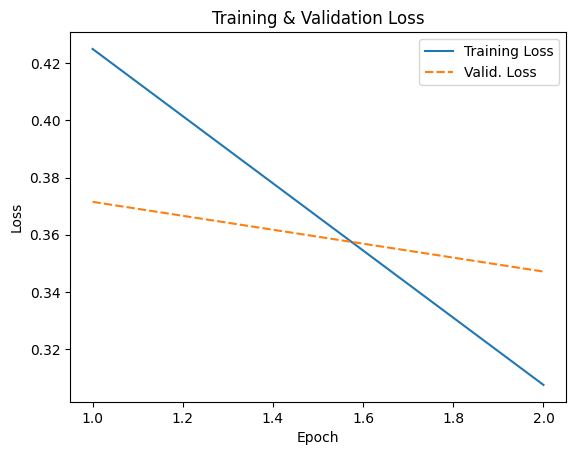

In [29]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.lineplot(data=df_stats[['Training Loss', 'Valid. Loss']])

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.show()

In [30]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [31]:
output_dir = '/kaggle/working/gpt2-fa-formalize'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
configuration.save_pretrained(output_dir)

# !cp /kaggle/working/gpt2/tokenizer.json /kaggle/working/gpt2-fa-formalize/

In [32]:
from transformers import TFAutoModelForCausalLM
tf_model = TFAutoModelForCausalLM.from_pretrained("/kaggle/working/gpt2-fa-formalize/", from_pt=True)
print(tf_model.summary())
tf_model.save_pretrained("/kaggle/working/gpt2-fa-formalize-tf")


!cp /kaggle/working/gpt2-fa-formalize-tf/tf_model.h5 /kaggle/working/gpt2-fa-formalize
!rm -rf /kaggle/working/gpt2-fa-formalize-tf

I0000 00:00:1755164973.090365      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8546 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755164973.091074      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  118099200 
 er)                                                             
                                                                 
Total params: 118099200 (450.51 MB)
Trainable params: 118099200 (450.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
def generator(informal, max_length=128, num_return_sequences=3):
    model.eval()
    prompt = f"<s><|startoftext|>[Informal]{normalize_text(informal)}[Formal]"

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=num_return_sequences
    )

    outputs = []
    for i, output in enumerate(decoded_outputs):
        o = tokenizer.decode(output, skip_special_tokens=False)
        o = o.replace("<s>", "").replace("</s>", "").replace("<|startoftext|>", "").replace("<|endoftext|>", "").replace("<pad>", "")
        pattern = r'\[Informal\].*?\[Formal\]'
        o = re.sub(pattern, '', o)
        outputs.append(o)

    if num_return_sequences > 1:
        print('Input: ', informal, "\n")
        print('Prompt: ', prompt, "\n")
        print('Outputs: ')

        for out in outputs:
            print(out)

    return outputs

In [34]:
out = generator("امروز روز خوبیه")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  امروز روز خوبیه 

Prompt:  <s><|startoftext|>[Informal]امروز روز خوبیه[Formal] 

Outputs: 
امروز روز خوبی است.
امروز روز خوبی است.
امروز روز خوبی است.


In [35]:
out = generator("اخه چه فایده داره این کار!!!")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  اخه چه فایده داره این کار!!! 

Prompt:  <s><|startoftext|>[Informal]اخه چه فایده داره این کار!!![Formal] 

Outputs: 
آخر این کار چه فایده دارد؟!
آخر این کار چه فایده‌ای دارد!
آخر این کار چه فایده دارد!


In [36]:
out = generator("بنظرت کارما میگیرتش؟!")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  بنظرت کارما میگیرتش؟! 

Prompt:  <s><|startoftext|>[Informal]بنظرت کارما میگیرتش؟![Formal] 

Outputs: 
به نظرت کارما آن را گیر می‌گیرد؟!
به نظرت کارما آن را می‌گیرد؟!
به نظرت کارما او را می‌گیرد؟!


In [37]:
out = generator("واقعا خیلی حیف شد... حقمون نبود اینقدر ظلم بشه.. من خدایی میترسم")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  واقعا خیلی حیف شد... حقمون نبود اینقدر ظلم بشه.. من خدایی میترسم 

Prompt:  <s><|startoftext|>[Informal]واقعا خیلی حیف شد... حقمون نبود اینقدر ظلم بشه.. من خدایی میترسم[Formal] 

Outputs: 
واقعاً خیلی حیف شد... حقمان نبود این‌قدر ظلم بشود. من خدای می‌ترسم.
واقعاً خیلی حیف شد، حقمان نبود این‌قدر ظلم بشود؛ من خدایی می‌ترسم.
واقعاً خیلی حیف شد؛ حقمان نبود که این‌قدر ظلم بشود، من خدای می‌ترسم


In [38]:
from nltk.translate.bleu_score import sentence_bleu
from hazm import *

normalizer = Normalizer()
i = 341
# Define your reference text (the formal version of the input text)
reference_text = df_parsmap['formalForm'][i]

# Define your generated text (the output of your fine-tuned GPT-2 model)
generated_text = generator(df_parsmap['inFormalForm'][i], num_return_sequences=1)[0]

# Tokenize the reference and generated texts
reference_tokens = word_tokenize(reference_text)
generated_tokens = word_tokenize(generated_text)

# Calculate the BLEU score
bleu_score = sentence_bleu([reference_tokens], generated_tokens)

# Print the BLEU score
print("BLEU score:", bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


BLEU score: 9.53091075863908e-155


In [39]:
from nltk.translate.bleu_score import SmoothingFunction

# Define the size of the random sample
sample_size = 1000

# Select a random sample of the dataset
sample_indices = random.sample(range(len(df_parsmap)), sample_size)
reference_texts = [df_parsmap.iloc[i]['formalForm'] for i in sample_indices]
generated_texts = [generator(df_parsmap.iloc[i]['inFormalForm'], num_return_sequences=1)[0] for i in sample_indices]

# Tokenize the reference and generated texts
reference_tokens = [word_tokenize(text) for text in reference_texts]
generated_tokens = [word_tokenize(text) for text in generated_texts]

# Calculate the BLEU scores with smoothing
bleu_scores = []
smoothing_func = SmoothingFunction()
for ref_tokens, gen_tokens in zip(reference_tokens, generated_tokens):
    bleu_score = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothing_func.method1)
    bleu_scores.append(bleu_score)

# Calculate the average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Print the average BLEU score
print("Average BLEU score on random sample of size", sample_size, ":", avg_bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attentio

Average BLEU score on random sample of size 1000 : 0.6687343529663211


In [ ]:
from huggingface_hub import login
# login(token="")

repo_id = "AylinNaebzadeh/gpt2-fa-formalize"
model.push_to_hub(repo_id)      # uploads adapters
tokenizer.push_to_hub(repo_id)  # uploads tokenizer

